In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, struct

In [2]:
from utils.latticeeasy import *
from utils.extract_utils import shift_volume
from utils.extract_utils import interpolate

# Load grid.img file

In [3]:
"""
Directory to a .img file.
"""

grid_dir = "/media/yangelaxue/TRANSFER/Colliding_Oscillons/alpha_beta-0.25_80_351.512634/smash_osc22_osc4_0.01c_v1"
grid_file = os.path.join(grid_dir,"test smash.img")
os.path.exists(grid_file)

True

In [4]:
"""
Dimensions of the inflaton field (and its time derivative).
You need to know this beforehand.
"""

domain_dimensions = (256,)*3

In [5]:
"""
Read .img file.
"""

n_points = np.product(domain_dimensions)
with open(grid_file,'rb') as grid:
    
    grid_content = grid.read()
    idx, = struct.unpack("i" * 1, grid_content[:4])
    t_start, = struct.unpack("f" * 1, grid_content[4:8])
    a, = struct.unpack("f" * 1, grid_content[8:12])
    ap, = struct.unpack("f" * 1, grid_content[12:16])
    
    phi_adv = struct.unpack("f" * n_points, grid_content[16:16+4*n_points])
    phip = struct.unpack("f" * n_points, grid_content[16+4*n_points:])

In [13]:
"""
Reshape phi and phip field (program units)
"""

phi_adv = np.array(phi_adv).reshape(domain_dimensions)
phip = np.array(phip).reshape(domain_dimensions)

"""
Take 1/2 time step back.
You need to know the time step beforehand.
"""
dt_pr = 0.0005
phi = phi_adv - dt_pr/2 * phip

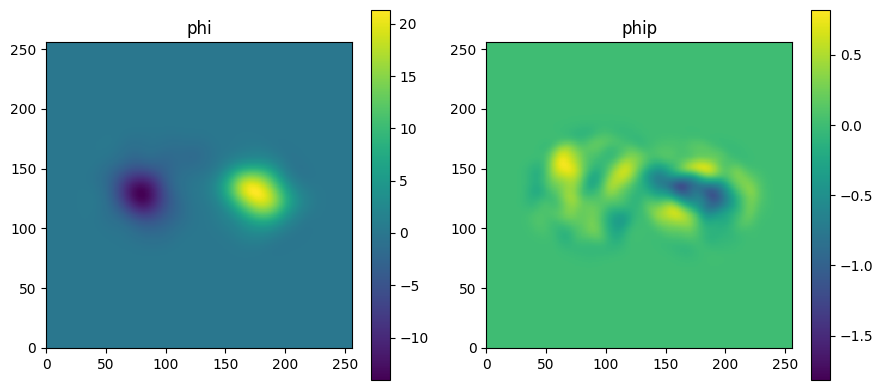

In [14]:
"""
View fields.
"""

N = domain_dimensions[0]

fig, axes = plt.subplots(1,2,figsize=(9,4),tight_layout=True)

offset = 0

mesh = axes[0].pcolormesh(phi[:,N//2-offset].T,
                          vmin=phi.min(),vmax=phi.max()
                         )
fig.colorbar(mesh,)
axes[0].set_title("phi")

mesh = axes[1].pcolormesh(phip[:,N//2-offset].T,
                          vmin=phip.min(),vmax=phip.max()
                         )
fig.colorbar(mesh,)
axes[1].set_title("phip")

for ax in axes:
    ax.set_aspect('equal')

plt.show()

# Interpolate grid down

In [15]:
shape_i = (128+64,)*3
shape_i

(192, 192, 192)

In [16]:
phi_i, phip_i = interpolate(shape_i, phi, phip)

# Add to empty background

In [17]:
def add_emptybackground(bg, *vals):
    
    for val in vals:
        assert vals[0].shape == val.shape
    
    shape_bg = bg.shape[0]
    shape_vals = vals[0].shape[0]
    
    corner_idx = shape_bg//2 - shape_vals//2
    
    vals_bg = ()
    for val in vals:
        val_bg = bg.copy()
        val_bg[corner_idx:corner_idx+shape_vals,corner_idx:corner_idx+shape_vals,corner_idx:corner_idx+shape_vals] = val
        vals_bg += (val_bg,)
    
    return vals_bg

In [18]:
shape_bg = (256,)*3

bg = np.zeros(shape_bg)

phi_bg, phip_bg = add_emptybackground(bg, phi_i, phip_i)

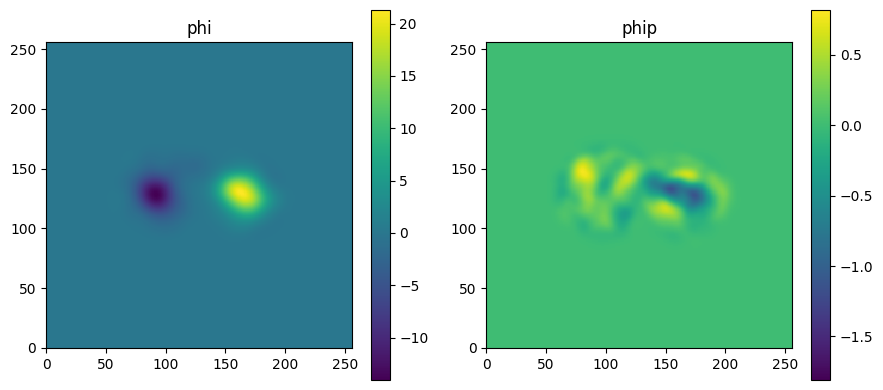

In [19]:
"""
View fields.
"""

N = shape_bg[0]

fig, axes = plt.subplots(1,2,figsize=(9,4),tight_layout=True)

offset = 0

mesh = axes[0].pcolormesh(phi_bg[:,N//2-offset].T,
                          vmin=phi_bg.min(),vmax=phi_bg.max()
                         )
fig.colorbar(mesh,)
axes[0].set_title("phi")

mesh = axes[1].pcolormesh(phip_bg[:,N//2-offset].T,
                          vmin=phip_bg.min(),vmax=phip_bg.max()
                         )
fig.colorbar(mesh,)
axes[1].set_title("phip")

for ax in axes:
    ax.set_aspect('equal')

plt.show()

# Save as grid.img

In [24]:
"""
Advance phi_bg by half a timestep.
"""

dt_pr = 0.001

phi_bg_adv = phi_bg + dt_pr/2*phip_bg

In [25]:
alpha = 0.25
beta = 80
f0 = 0.080613

L_pr = 0.4062255 * shape_bg[0]/shape_i[0]
L_pr

0.5416340000000001

In [26]:
N = shape_bg[0]
n_points = N*N*N

fname_o = f"test smash.img"
datname_o = f"test smash.img.dat"
fdir = os.path.join(grid_dir,f"larger_box")

if not os.path.exists(fdir):
    os.makedirs(fdir)

with open(os.path.join(fdir, datname_o), 'w') as dat:
    dat.write(f"N = {phi_bg_adv.shape}\n")
    dat.write(f"L_pr = {L_pr}\n")
    dat.write(f"dt_pr = {dt_pr}\n")
    dat.write(f"alpha = {alpha}\n")
    dat.write(f"beta = {beta}\n")
    dat.write(f"f0 = {f0}\n")
    dat.write(f"\n")
    
#     dat.write(f"Spatial resolution change {data.domain_dimensions} -> {shape_i}\n")
#     dat.write(f"Temporal resolution change {data.dt_pr} -> {dt_pr}\n")
#     dat.write(f"Run simulations from t_pr = {data.t[timeslice]}\n")
    dat.write(f"output_dir = {fdir}\n")
    
with open(os.path.join(fdir, fname_o),'wb') as f_o:
    
    f_o.write(struct.pack('<i',-1))
#     f_o.write(struct.pack('<f',data.t[timeslice]))
    f_o.write(struct.pack('<f',0))
    f_o.write(struct.pack('<f',a))
    f_o.write(struct.pack('<f',ap))
    
    f_o.write(struct.pack('<'+'f'*n_points,*phi_bg_adv.flatten()))
    f_o.write(struct.pack('<'+'f'*n_points,*phip_bg.flatten()))